In [200]:
# This example is actually from stat quesabst
import pandas as pd
import nltk
import matplotlib.pyplot as plt

real_emails = {
  1: {
    "content": "Dear friend, would you like to grab dinner next week?"
  },
  2: {
    "content": "Dear friend, I owe you some money, and I'll transfer it today."
  },
  3: {
    "content": "Dear friend, let's meet for breakfast tomorrow at our favorite spot."
  },
  4: {
    "content": "Dear friend, could you please lend me some cash? I'll pay you back next week."
  },
  5: {
    "content": "Dear friend, let's catch up over lunch and discuss our plans."
  },
  6: {
    "content": "Dear colleague, I need your help with some financial matters."
  },
  7: {
    "content": "Dear buddy, let's have lunch together and celebrate your recent success."
  },
  8: {
    "content": "Dear pal, I'll treat you to lunch as a token of appreciation for your support."
  }
}

spam_emails = {
  1: {
    "content": "Dear recipient, Congratulations! You've won a huge sum of money, claim it now!"
  },
  2: {
    "content": "Attention friend, Earn quick money from home with our guaranteed investment scheme."
  },
  3: {
    "content": "Dear lucky winner, Act now to receive your share of the money - it's a once-in-a-lifetime opportunity!"
  },
  4: {
    "content": "URGENT: Money-making secret revealed! Unlock your financial success today."
  }
}


df_real = pd.DataFrame(real_emails).T
df_spam = pd.DataFrame(spam_emails).T


real_emails_concat = " ".join(df_real['content']).lower()

real_emails_concat = real_emails_concat.replace('-', ' ')
real_emails_concat = real_emails_concat.replace('!', '').replace('?', '').replace('.', '').replace(',', '')

stemmer = nltk.PorterStemmer()

real_emails_bag_of_words = [stemmer.stem(word) for word in real_emails_concat.split() if len(word) > 0]

spam_emails_concat = " ".join(df_spam['content']).lower()
spam_emails_concat = spam_emails_concat.replace('-', ' ')
spam_emails_concat = spam_emails_concat.replace('!', '').replace('?', '').replace('.', '').replace(',', '')


spam_emails_bag_of_words = [stemmer.stem(word) for word in spam_emails_concat.split() if len(word) > 0]

df_real.insert(0, 'spam_flag', 0)
df_spam.insert(0, 'spam_flag', 1)
df = pd.concat([df_real, df_spam]).reset_index(drop=True)
df.head(50)

#print(real_emails_bag_of_words)
#print(spam_emails_bag_of_words)

,spam_flag,content
0,0,"Dear friend, would you like to grab dinner nex..."
1,0,"Dear friend, I owe you some money, and I'll tr..."
2,0,"Dear friend, let's meet for breakfast tomorrow..."
3,0,"Dear friend, could you please lend me some cas..."
4,0,"Dear friend, let's catch up over lunch and dis..."
5,0,"Dear colleague, I need your help with some fin..."
6,0,"Dear buddy, let's have lunch together and cele..."
7,0,"Dear pal, I'll treat you to lunch as a token o..."
8,1,"Dear recipient, Congratulations! You've won a ..."
9,1,"Attention friend, Earn quick money from home w..."


In [202]:
def word_counter(all_words, words_of_interest):
    if isinstance(words_of_interest, str):
        words_of_interest = [words_of_interest]
    word_count = {}
    for word in all_words:
        if word in words_of_interest:
            if word in word_count:
                word_count[word] += 1
            else:
                word_count[word] = 1
    return word_count


print("Real")
word_counts_real = word_counter(real_emails_bag_of_words, ['dear', 'friend', 'lunch', 'money'])

print(word_counts_real)
print("Spam")
word_counts_spam = word_counter(spam_emails_bag_of_words, ['dear', 'friend', 'lunch', 'money'])
print(word_counts_spam)

Real
{'dear': 8, 'friend': 5, 'money': 1, 'lunch': 3}
Spam
{'dear': 2, 'money': 4, 'friend': 1}


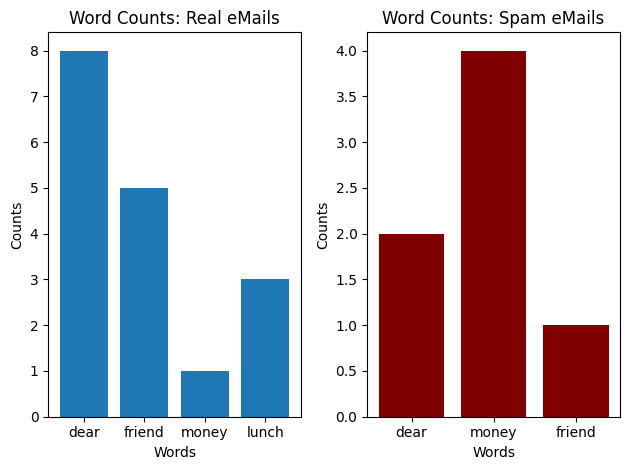

In [203]:
# Real 

words_real = list(word_counts_real.keys())
counts_real = list(word_counts_real.values())

words_spam = list(word_counts_spam.keys())
counts_spam = list(word_counts_spam.values())


# Subplot 1
plt.subplot(1, 2, 1)  # Create the first subplot
plt.bar(words_real, counts_real)
plt.xlabel('Words')
plt.ylabel('Counts')
plt.title('Word Counts: Real eMails')

# Subplot 2
plt.subplot(1, 2, 2)  # Create the second subplot
plt.bar(words_spam, counts_spam, color='maroon')  # Set the color to orange
plt.xlabel('Words')
plt.ylabel('Counts')
plt.title('Word Counts: Spam eMails')

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

In [88]:
nb = NaiveBayesSpamClassifier(emails_df=df)
nb.set_bags_of_words()
nb.set_words_of_interest(['dear', 'friend', 'lunch', 'money'])
classification = nb.classify_email('Lunch Money Money Money Money')
print('----------------------------------------------------------')
#print("{:.6f}".format(your value here));

print("Probability of Real Email: {:.8f}".format(nb.overall_probabilities['real']))
print("Probability of Spam Email: {:.8f}".format(nb.overall_probabilities['spam']))
print("Classification:", classification)

Testing Real probability
word_counts_real {'money': 1, 'lunch': 3}
len_real_bag 17
word_probs_real {'money': 0.058823529411764705, 'lunch': 0.17647058823529413}
real_prob_words 1
----------------------------------------------------------
Probability of Real Email: 0.00000141
Probability of Spam Email: 0.00000000
Classification: real


In [208]:
class NaiveBayesSpamClassifier:
    def __init__(self, emails_df, alpha=0):
        self.emails_df = emails_df
        self.limit_to_words = None
        self.test_email = None
        self.test_email_bag = None
        self.bag_all = None
        self.bag_real = None
        self.bag_spam = None
        self.overall_probabilities = None
        self.alpha = alpha
        self.words_of_interest = None
    
    def set_words_of_interest(self, words_of_interest):
        self.words_of_interest = words_of_interest
        
        for bag in [self.bag_spam, self.bag_real]: # iterating on a copy since removing from source will mess things up
            for word in list(bag):
                if word in words_of_interest:
                    pass
                else:
                    bag.remove(word)
    
    def get_spam_probability(self):
        num_total_records = self.emails_df.shape[0]
        num_spam_records = self.emails_df.spam_flag.sum()
        return float(num_spam_records)/float(num_total_records)
    
    def get_nonspam_probability(self):
        return 1.0 - self.get_spam_probability()
    
    def set_bags_of_words(self):
        df_real = self.emails_df[self.emails_df.spam_flag != 1]
        df_spam = self.emails_df[self.emails_df.spam_flag == 1]
        stemmer = nltk.PorterStemmer()

        real_emails_concat = " ".join(df_real['content']).lower()
        spam_emails_concat = " ".join(df_spam['content']).lower()

        real_emails_concat = real_emails_concat.replace('-', ' ')
        real_emails_concat = real_emails_concat.replace('!', '').replace('?', '').replace('.', '').replace(',', '')
        spam_emails_concat = spam_emails_concat.replace('-', ' ')
        spam_emails_concat = spam_emails_concat.replace('!', '').replace('?', '').replace('.', '').replace(',', '')        
        
        real_emails_bag_of_words = [stemmer.stem(s) for s in real_emails_concat.split() if len(s) > 0]
        spam_emails_bag_of_words = [stemmer.stem(s) for s in spam_emails_concat.split() if len(s) > 0]
        
        self.bag_real = real_emails_bag_of_words
        self.bag_spam = spam_emails_bag_of_words
        
    
    def word_counter(self, all_words, email_bag_words):
        if isinstance(email_bag_words, str):
            email_bag_words = [email_bag_words]
                
        word_count = {}
        for word in self.words_of_interest:
            word_count[word] = self.alpha
        
        for word in all_words:
            if word in word_count:
                word_count[word] += 1
        
        return word_count
    
    def test_spam_probability_words(self):
        word_counts_spam = self.word_counter(self.bag_spam, self.test_email_bag)
        len_spam_bag = len(self.bag_spam)
        len_spam_bag_with_alpha = len(self.bag_spam) + (self.alpha * len(self.words_of_interest))        
        word_probs_spam = {s: word_counts_spam[s]/len_spam_bag_with_alpha for s in word_counts_spam}
        
        spam_prob_words = 1
        for k in self.test_email_bag:#word_probs_spam:
            if k in word_probs_spam:
                spam_prob_words *= word_probs_spam[k]
            else:
                spam_prob_words *= 0
                
        return spam_prob_words
        
    def test_real_probability_words(self):        
        word_counts_real = self.word_counter(self.bag_real, self.test_email_bag)
        len_real_bag = len(self.bag_real)
        len_spam_bag_with_alpha = len(self.bag_real) + (self.alpha * len(self.words_of_interest))        

        word_probs_real = {s: word_counts_real[s] / len_spam_bag_with_alpha for s in word_counts_real}
        
        real_prob_words = 1

        for k in self.test_email_bag:#word_probs_real
            if k in word_probs_real:
                real_prob_words *= word_probs_real[k]
            else:
                real_prob_words *= 0

        
        return real_prob_words


    def classify_email(self, email_txt):
        self.test_email = email_txt
        self.test_email_bag = email_txt.lower().replace('-', ' ')
        self.test_email_bag = self.test_email_bag.replace('!', '').replace('?', '').replace('.', '').replace(',', '')
        self.test_email_bag = self.test_email_bag.split(' ')
        
        self.overall_probabilities = {
            'spam': self.get_spam_probability() * self.test_spam_probability_words(),
            'real': self.get_nonspam_probability() * self.test_real_probability_words()
        }
        
        if self.overall_probabilities['spam'] > self.overall_probabilities['real']:
            return 'spam'
        elif self.overall_probabilities['real'] > self.overall_probabilities['spam']:
            return 'real'
        else:
            return '50/50'
        
        
        
# Example from
# https://www.youtube.com/watch?v=O2L2Uv9pdDA

nb = NaiveBayesSpamClassifier(emails_df=df, alpha=1)
nb.set_bags_of_words()
nb.set_words_of_interest(['dear', 'friend', 'lunch', 'money'])
classification = nb.classify_email('Lunch Money Money Money Money')
print('----------------------------------------------------------')

print("Probability of Real Email: {:.8f}".format(nb.overall_probabilities['real']))
print("Probability of Spam Email: {:.8f}".format(nb.overall_probabilities['spam']))
print("Classification:", classification)


----------------------------------------------------------
Probability of Real Email: 0.00001045
Probability of Spam Email: 0.00129359
Classification: spam
